### Import dependencies

In [27]:
import matplotlib.pyplot as plt

import polars_bio as pb
import pandas as pd

### Usage examples

#### Usage example - .fastq file

In [29]:
result = pb.base_sequence_quality("example.fastq", output_type="pandas.DataFrame", target_partitions=2).sort_values(by="pos")
print(result)

    pos     avg         q1     median         q3      lower      upper
77    0  30.135  31.213636  33.722222  34.482143  26.310877  39.384903
94    1  31.210  31.275000  34.086364  34.538636  26.379545  39.434091
51    2  32.015  31.356383  34.094595  34.542793  26.576768  39.322408
22    3  35.690  35.483333  37.208661  37.600394  32.307743  40.775984
48    4  35.680  35.552885  37.208661  37.600394  32.481621  40.671657
..  ...     ...        ...        ...        ...        ...        ...
67   96  31.315  32.795455  34.824324  35.508824  28.725401  39.578877
57   97  30.670  31.575000  34.890625  35.557229  25.601657  41.530572
2    98  31.550  32.107143  34.890625  35.537791  26.961171  40.683762
45   99  31.250  32.093750  34.712500  35.455357  27.051339  40.497768
27  100  31.105  31.250000  34.154762  35.250000  25.250000  41.250000

[101 rows x 7 columns]


##### Results visualization


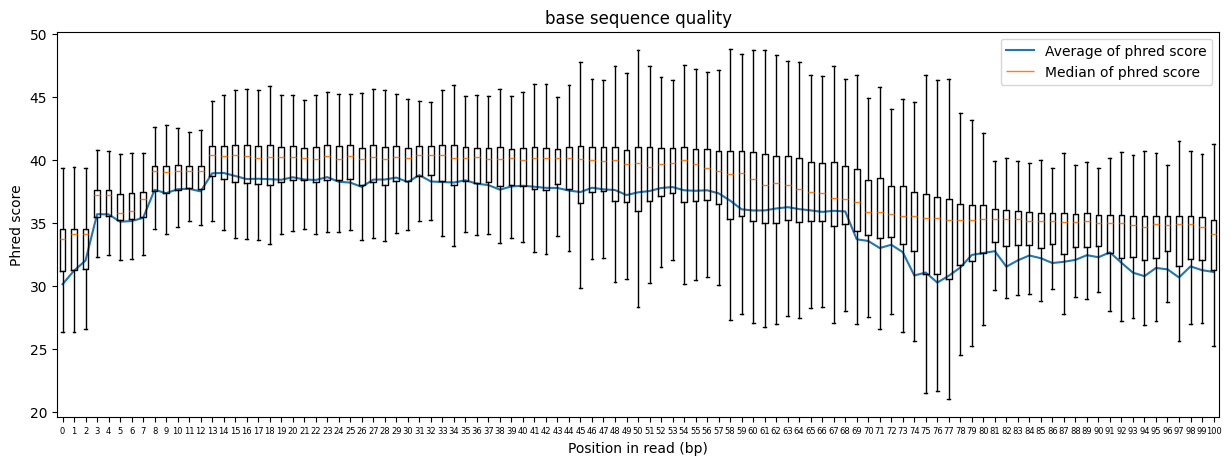

In [30]:
boxes = [
    {
        "label": int(row["pos"]),
        "whislo": row["lower"],
        "q1": row["q1"],
        "med": row["median"],
        "q3": row["q3"],
        "whishi": row["upper"],
    }
    for _, row in result.iterrows()
]


fig, ax = plt.subplots()
fig.set_size_inches(15, 5)


plot = ax.plot(result["pos"] + 1, result["avg"])
box_plot = ax.bxp(boxes, showfliers=False)

ax.set_title("base sequence quality")
ax.set_ylabel("Phred score")
ax.set_xlabel("Position in read (bp)")

ax.legend(
    [plot[0], box_plot["medians"][0]],
    ["Average of phred score", "Median of phred score"],
)


for label in ax.get_xticklabels():
    label.set_fontsize(6)


plt.show()

#### Usage example - .csv file

In [3]:
pb.base_sequence_quality("example.csv")

pos,avg,q1,median,q3,lower,upper
u64,f64,f64,f64,f64,f64,f64
47,37.665,37.535714,39.921053,41.060185,32.249008,46.346892
90,32.275,33.183333,34.986842,35.63961,29.498918,39.324026
26,37.855,38.028846,40.078947,40.951754,33.644484,45.336117
7,35.4,35.465909,36.90625,37.487374,32.433712,40.519571
3,35.69,35.483333,37.208661,37.600394,32.307743,40.775984
…,…,…,…,…,…,…
19,38.425,38.2375,40.238462,41.004902,34.086397,45.156005
94,30.775,32.057692,34.651515,35.51,26.879231,40.688462
17,38.505,38.125,40.127451,41.09375,33.671875,45.546875


#### Usage example - .parquet file

In [20]:
pb.base_sequence_quality("example.parquet")

pos,avg,q1,median,q3,lower,upper
u64,f64,f64,f64,f64,f64,f64
88,32.065,33.068182,35.06875,35.690625,29.134517,39.62429
43,37.775,38.114583,40.126866,40.869403,33.982354,45.001632
49,37.21,36.678571,39.645833,40.763889,30.550595,46.891865
67,35.96,34.723684,36.972222,39.81,27.094211,47.439474
36,38.11,38.178571,40.25,40.960714,34.005357,45.133929
…,…,…,…,…,…,…
74,30.83,32.75,35.532609,37.485294,25.647059,44.588235
83,32.03,33.25,35.28481,35.914557,29.253165,39.911392
81,32.76,33.514706,35.297101,36.073529,29.676471,39.911765


#### Usage example - `polars.lazyframe.frame.LazyFrame` object

In [23]:
a_lazyframe = pb.read_fastq("./example.fastq")
print(type(a_lazyframe))
pb.base_sequence_quality(a_lazyframe)

INFO:polars_bio:Table: example registered for path: ./example.fastq


<class 'polars.lazyframe.frame.LazyFrame'>


200rows [00:00, 63535.62rows/s]


pos,avg,q1,median,q3,lower,upper
u64,f64,f64,f64,f64,f64,f64
56,37.59,36.826923,39.396552,40.895833,30.723558,46.999199
16,38.48,38.197917,40.324561,41.181452,33.722614,45.656754
83,32.03,33.25,35.28481,35.914557,29.253165,39.911392
92,31.835,32.229167,35.005882,35.591176,27.186152,40.634191
26,37.855,38.028846,40.078947,40.951754,33.644484,45.336117
…,…,…,…,…,…,…
97,30.67,31.575,34.890625,35.557229,25.601657,41.530572
46,37.79,37.479167,39.975,41.042453,32.134237,46.387382
87,31.915,32.55,35.087838,35.760135,27.734797,40.575338


#### Usage example - `polars.dataframe.frame.DataFrame` object

In [24]:
a_lazyframe = pb.read_fastq("./example.fastq")
a_dataframe = a_lazyframe.collect()
print(type(a_dataframe))
pb.base_sequence_quality(a_dataframe)

INFO:polars_bio:Table: example registered for path: ./example.fastq
200rows [00:00, 88450.11rows/s]

<class 'polars.dataframe.frame.DataFrame'>


pos,avg,q1,median,q3,lower,upper
u64,f64,f64,f64,f64,f64,f64
1,31.21,31.275,34.086364,34.538636,26.379545,39.434091
64,36.095,35.064815,37.7,40.145833,27.443287,47.767361
43,37.775,38.114583,40.126866,40.869403,33.982354,45.001632
16,38.48,38.197917,40.324561,41.181452,33.722614,45.656754
8,37.625,37.535714,39.118421,39.554825,34.507049,42.58349
…,…,…,…,…,…,…
21,38.445,38.37069,40.134921,40.924603,34.539819,44.755473
78,31.46,31.6875,35.263636,36.486842,24.488487,43.685855
36,38.11,38.178571,40.25,40.960714,34.005357,45.133929


#### Usage example - `pandas.core.frame.DataFrame` object

In [7]:
a_lazyframe = pb.read_fastq("./example.fastq")
a_pandas_dataframe = a_lazyframe.collect().to_pandas()
print(type(a_pandas_dataframe))
pb.base_sequence_quality(a_pandas_dataframe)

INFO:polars_bio:Table: example registered for path: ./example.fastq
200rows [00:00, 91799.17rows/s]

<class 'pandas.core.frame.DataFrame'>


pos,avg,q1,median,q3,lower,upper
u64,f64,f64,f64,f64,f64,f64
71,33.005,33.791667,35.851351,38.583333,26.604167,45.770833
74,30.83,32.75,35.532609,37.485294,25.647059,44.588235
45,37.45,36.59375,40.071429,41.077273,29.868466,47.802557
49,37.21,36.678571,39.645833,40.763889,30.550595,46.891865
75,31.06,30.958333,35.418367,37.283333,21.470833,46.770833
…,…,…,…,…,…,…
50,37.425,35.975,39.770833,41.060185,28.347222,48.687963
3,35.69,35.483333,37.208661,37.600394,32.307743,40.775984
0,30.135,31.213636,33.722222,34.482143,26.310877,39.384903
